## Instalar bibliotecas necesarias

In [2]:
!pip install torch                    # Install the PyTorch library for deep learning.
!pip install --upgrade transformers   # Install and upgrade the Transformers library for NLP tasks.
!pip install pandas                   # Install the Pandas library for data manipulation.
!pip install scikit-learn             # Install scikit-learn for machine learning tasks.
!pip install sentencepiece            # Install SentencePiece for text tokenization.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


## Lectura de archivos drive

In [24]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/proyecto_nlp/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset  modelo2  modelo3


## Análisis

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
corpus = pd.read_csv('/content/drive/MyDrive/proyecto_nlp/dataset/D57000_complete.csv', delimiter=';')

corpus.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,Moreno intenta apaciguar el flanco sanitario m...,El presidente abre la puerta a unos comicios e...,19/04/2022
1,ID,1,La Abogacía del Estado se retira como acusació...,"En un escrito, la abogada del Estado Rosa Marí...",17/09/2021
2,ID,0,Las promesas incumplidas de Pablo Echenique en...,Este lunes y martes la Asamblea de Madrid acog...,12/09/2022
3,ID,1,Sánchez defiende 'resolver el problema' de la ...,Resulta evidente que la ley ha tenido algunos ...,07/02/2023
4,ID,1,Ian Gibson cierra la lista electoral de la con...,"El hispanista, que ya ocupó un puesto simbólic...",12/04/2023


In [26]:
# --> Informacion del corpus
corpus.info()
print("-"*80)

# --> Cantidad de registros
print(f"[+]Cantidad de registros: {len(corpus)}")
print("-"*80)

# --> Cantidad de registros por clase
print(corpus['Label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57231 entries, 0 to 57230
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57231 non-null  object
 1   Label        57231 non-null  int64 
 2   Titulo       57231 non-null  object
 3   Descripcion  57231 non-null  object
 4   Fecha        57231 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB
--------------------------------------------------------------------------------
[+]Cantidad de registros: 57231
--------------------------------------------------------------------------------
1    33351
0    23880
Name: Label, dtype: int64


In [27]:
# --> Revisar si hay desbalance de clases en el corpus
IR = corpus['Label'].value_counts()[1] / corpus['Label'].value_counts()[0]

print(f"[+]Valor de IR: {IR:.2f}")
print("[+]Desbalance de clases" if IR > 1.5 else "[+]No hay desbalance de clases")


[+]Valor de IR: 1.40
[+]No hay desbalance de clases


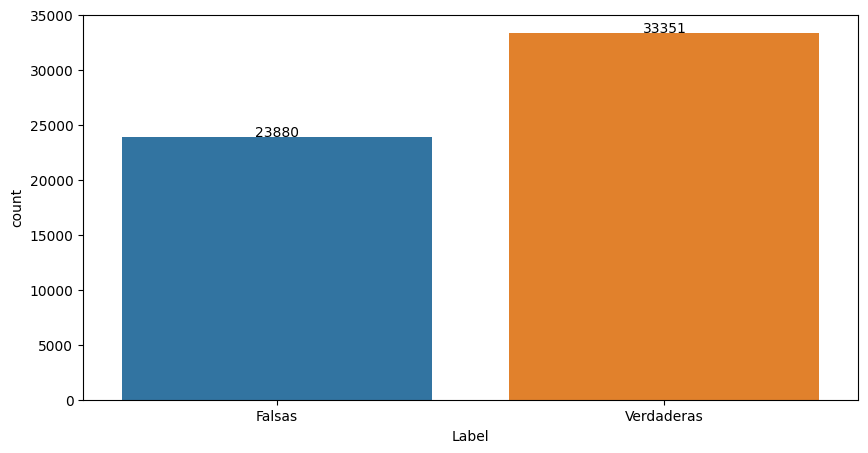

In [30]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Label', data=corpus)
plt.xticks([0, 1], ['Falsas', 'Verdaderas'])

# --> Cantidad de registros por clase dentro de la grafica de barras
for i in range(2):
    count = corpus['Label'].value_counts()[i]
    plt.text(i, count+100, count, ha='center')

plt.show()

## Entrenamiento

In [ ]:
# Bibliotecas necesarias
import torch
import pandas as pd
import random
import numpy as np
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef

In [ ]:
# Esto es para que los resultados sean reproducibles
seed = 26                                           # La semilla que queramos
random.seed(seed)                                   # Fijamos la semilla para random
np.random.seed(seed)                                # Fijamos la semilla para numpy (usado por pandas)
torch.manual_seed(seed)                             # Fijamos la semilla para torch
torch.cuda.manual_seed_all(seed)                    # Fijamos la semilla para cuda (GPU)

In [ ]:
# Cargar el dataset de entrenamiento
df = pd.read_csv("/content/drive/MyDrive/proyecto_nlp/dataset/D57000_complete.csv", delimiter=";")

df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,Moreno intenta apaciguar el flanco sanitario m...,El presidente abre la puerta a unos comicios e...,19/04/2022
1,ID,1,La Abogacía del Estado se retira como acusació...,"En un escrito, la abogada del Estado Rosa Marí...",17/09/2021
2,ID,0,Las promesas incumplidas de Pablo Echenique en...,Este lunes y martes la Asamblea de Madrid acog...,12/09/2022
3,ID,1,Sánchez defiende 'resolver el problema' de la ...,Resulta evidente que la ley ha tenido algunos ...,07/02/2023
4,ID,1,Ian Gibson cierra la lista electoral de la con...,"El hispanista, que ya ocupó un puesto simbólic...",12/04/2023


In [ ]:
# Separar rasgos y etiquetas
X = df[["Titulo", "Descripcion", "Fecha"]]
y = df["Label"]

# Separar la informacion en conjuntos de entrenamiento y evaluacion
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(f"[+] Conjunto de train: {len(X_train)}")
print(f"[+] Conjunto de test: {len(X_eval)}")
print("-"*50)
print(f"[+]Total de datos: {len(X_train) + len(X_eval)}")

[+] Conjunto de train: 45784
[+] Conjunto de test: 11447
--------------------------------------------------
[+]Total de datos: 57231


In [ ]:
# Tokenizador de Roberta
tokenizer = RobertaTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

In [ ]:
# Codificar el conjunto de entrenamiento
train_encodings = tokenizer(
    X_train["Titulo"].tolist(),             # Lista de titulos
    X_train["Descripcion"].tolist(),        # Lista de descripciones
    X_train["Fecha"].tolist(),              # Lista de fechas
    padding="max_length",                   # Rellenar las secuencias hasta la longitud maxima
    truncation='only_second',               # Si la noticia excede la longitud maxima, se truncara el segundo campo
    max_length=128,                         # Longitud maxima de las secuencias
    return_tensors="pt"                     # Devolver los tensores de PyTorch
)

In [ ]:
# Codificar el conjunto de evaluacion
eval_encodings = tokenizer(                 # Mismo procedimiento que para el conjunto de entrenamiento
    X_eval["Titulo"].tolist(),
    X_eval["Descripcion"].tolist(),
    X_eval["Fecha"].tolist(),
    padding="max_length",
    truncation='only_second',               # Si la noticia excede la longitud maxima, se truncara el segundo campo
    max_length=128,
    return_tensors="pt"
)

In [ ]:
# Asignar las entradas codificadas a variables separadas
train_input_ids = train_encodings["input_ids"]
train_attention_masks = train_encodings["attention_mask"]

eval_input_ids = eval_encodings["input_ids"]
eval_attention_masks = eval_encodings["attention_mask"]

In [ ]:
# Crear TensorDatasets para entrenamiento y evaluacion
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(y_train.tolist()))
eval_dataset = TensorDataset(eval_input_ids, eval_attention_masks, torch.tensor(y_eval.tolist()))

In [ ]:
# Crear DataLoaders para cargar los datos en lotes
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Cargar el modelo pre-entrenado
model = RobertaForSequenceClassification.from_pretrained("PlanTL-GOB-ES/roberta-base-bne", num_labels=2)

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configurar el optimizador y el dispositivo de entrenamiento
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # Add weight decay for L2 regularization 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Configurar la tasa de dropout
dropout_rate = 0.1                              # Esto para que sea facil cambiarlo
model.classifier.dropout.p = dropout_rate       # Configurar la tasa de dropout para la capa de clasificacion

In [ ]:
# Modelo de entrenamiento
model.train()

best_mcc = -1.0                                                   # Best MCC value
best_epoch = -1                                                   # Epoch where the best MCC was achieved
best_model_path = "/content/drive/MyDrive/proyecto_nlp/modelo/"   # Path to save the best model

In [ ]:
for epoch in range(10):
    print(f"[+]Epoca {epoch + 1}")
    total_train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    total_batches = len(train_dataloader)

    for batch_idx, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss

        logits = outputs.logits

        total_train_loss += loss.item()

        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        # Calcular el porcentaje de avance
        progress_percentage = (batch_idx / total_batches) * 100

        # Imprimir el porcentaje de avance
        print(f"\rIteración {batch_idx}/{total_batches} - Avance: {progress_percentage:.2f}%", end="")


    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Evaluation on the evaluation set
    model.eval()

    print("\n[+]Evaluando el modelo...")
    with torch.no_grad():
        total_eval_loss = 0.0
        eval_predictions = []
        eval_labels = []

        total_eval_batches = len(eval_dataloader)

        for eval_batch_idx, eval_batch in enumerate(eval_dataloader, 1):
            eval_batch = tuple(t.to(device) for t in eval_batch)
            input_ids, attention_masks, labels = eval_batch

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            _, predicted_labels = torch.max(logits, 1)
            eval_predictions.extend(predicted_labels.tolist())
            eval_labels.extend(labels.tolist())

            # Calcular el porcentaje de avance en la evaluación
            eval_progress_percentage = (eval_batch_idx / total_eval_batches) * 100

            # Imprimir el porcentaje de avance en la evaluación
            print(f"\rEvaluación - Iteración {eval_batch_idx}/{total_eval_batches} - Avance: {eval_progress_percentage:.2f}%", end="")

        eval_loss = total_eval_loss / len(eval_dataloader)
        eval_accuracy = accuracy_score(eval_labels, eval_predictions)
        eval_f1 = f1_score(eval_labels, eval_predictions)
        eval_recall = recall_score(eval_labels, eval_predictions)
        eval_mcc = matthews_corrcoef(eval_labels, eval_predictions)

    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Eval Loss: {eval_loss:.4f} | Eval Accuracy: {eval_accuracy:.4f}")
    print(f"Eval F1: {eval_f1:.4f}")
    print(f"Eval Recall: {eval_recall:.4f}")
    print(f"Eval MCC: {eval_mcc:.4f}")
    print("--------------------")

    # --------------------------------------| Guardado del mejor modelo |-------------------------------------- #
    # Guardar el modelo si se consigue un MCC mayor
    if eval_mcc > best_mcc:
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        best_mcc = eval_mcc
        best_epoch = epoch + 1

# --------------------------------------| Resultados finales |-------------------------------------- #
print("Best model achieved at epoch:", best_epoch)
print("Best evaluation MCC:", best_mcc)
print("Model saved at:", best_model_path)

[+]Epoca 1
Iteración 2862/2862 - Avance: 100.00%
[+]Evaluando el modelo...
Evaluación - Iteración 716/716 - Avance: 100.00%Epoch 1
Train Loss: 0.0967 | Train Accuracy: 0.9621
Eval Loss: 0.0517 | Eval Accuracy: 0.9822
Eval F1: 0.9850
Eval Recall: 0.9867
Eval MCC: 0.9631
--------------------
[+]Epoca 2
Iteración 2862/2862 - Avance: 100.00%
[+]Evaluando el modelo...
Evaluación - Iteración 716/716 - Avance: 100.00%Epoch 2
Train Loss: 0.0267 | Train Accuracy: 0.9912
Eval Loss: 0.0484 | Eval Accuracy: 0.9849
Eval F1: 0.9872
Eval Recall: 0.9885
Eval MCC: 0.9687
--------------------
[+]Epoca 3
Iteración 2862/2862 - Avance: 100.00%
[+]Evaluando el modelo...
Evaluación - Iteración 716/716 - Avance: 100.00%Epoch 3
Train Loss: 0.0151 | Train Accuracy: 0.9957
Eval Loss: 0.0483 | Eval Accuracy: 0.9849
Eval F1: 0.9872
Eval Recall: 0.9880
Eval MCC: 0.9687
--------------------
[+]Epoca 4
Iteración 2862/2862 - Avance: 100.00%
[+]Evaluando el modelo...
Evaluación - Iteración 716/716 - Avance: 100.00%Epoc

## Testeo

In [3]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
import random
import numpy as np

In [4]:
# Configurar
seed = 26
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [5]:
# Rutas para el model entrenado y el tokenizador
model_path = "/content/drive/MyDrive/proyecto_nlp/modelo3/"
tokenizer_path = "/content/drive/MyDrive/proyecto_nlp/modelo3/"

In [6]:
# Cargar modelo entrenado y tokenizador
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [7]:
# Cargar nueva información
new_data_path = "/content/drive/MyDrive/proyecto_nlp/dataset/D11000_test.csv"
new_df = pd.read_csv(new_data_path, delimiter=';')

new_df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,0,La Audiencia Nacional da diez días a Rosalía M...,El Tribunal adopta esta decisión en una provid...,29/10/2020
1,ID,1,PP y Vox critican una charla feminista del Ayu...,Uno de los actos es un coloquio sobre el empod...,07/11/2018
2,ID,0,Álvarez de Toledo carga contra Boluarte tras s...,La dirigente popular aún no ha adoptado una de...,17/08/2020
3,ID,1,Unidos Podemos pregunta en el Senado sobre el ...,"El Senador de la formación morada, Joan Comore...",27/04/2018
4,ID,0,La Fiscalía pide dejar de considerar perjudica...,Anticorrupción sostiene que el vicepresidente ...,23/05/2020


In [8]:
# Configuracion de batch
batch_size = 16

In [9]:
# Tokenizar nueva información
new_encodings = tokenizer(
    new_df["Titulo"].tolist(),
    new_df["Descripcion"].tolist(),
    new_df["Fecha"].tolist(),
    padding="max_length",
    truncation='only_second',
    max_length=128,
    return_tensors="pt"
)

In [10]:
new_input_ids = new_encodings["input_ids"]
new_attention_masks = new_encodings["attention_mask"]

In [11]:
# Create a TensorDataset and DataLoader for the new data
new_dataset = TensorDataset(new_input_ids, new_attention_masks)
new_dataloader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
# Set the model to evaluation mode
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [14]:
# Perform inference on the new data
predictions = []
total_batches = len(new_dataloader)
with torch.no_grad():
    for batch_idx, batch in enumerate(new_dataloader):

        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks = batch

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        predictions.extend(predicted_labels.tolist())

        # Calcula el porcentaje de avance
        progress_percentage = (batch_idx / total_batches) * 100
        print(f'\rProgreso: {progress_percentage:.2f}%', end="")

Progreso: 99.86%

In [15]:
# Get true labels from the new data
true_labels = new_df["Label"].tolist()

# Calculate and print evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
mcc = matthews_corrcoef(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MCC: {mcc:.4f}")

Accuracy: 0.9972
F1 Score: 0.9976
Recall: 0.9979
MCC: 0.9941


## Predicciones

In [16]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
import random
import numpy as np

In [17]:
# Configurar
seed = 26
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [18]:
# Rutas para el model entrenado y el tokenizador
model_path = "/content/drive/MyDrive/proyecto_nlp/modelo3/"
tokenizer_path = "/content/drive/MyDrive/proyecto_nlp/modelo3/"

In [19]:
# Cargar modelo entrenado y tokenizador
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [20]:
# Configuracion de batch
batch_size = 16

In [21]:
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
# Ejemplo de datos para predecir
nuevo_titulo = "Moreno intenta apaciguar el flanco sanitario mientras enreda con la fecha de las elecciones"
nueva_descripcion = "El presidente abre la puerta a unos comicios en junio que no sean en domingo."
nueva_fecha = "19/04/2022"
# nuevo_titulo = "Las promesas incumplidas de Pablo Echenique en sanidad, educación y vivienda"
# nueva_descripcion = "Este lunes y martes la Asamblea de Madrid acogerá el debate del estado de la región. El último se celebró hace dos años, el 14 de septiembre de 2020."
# nueva_fecha = "12/09/2022"

# Tokeniza el nuevo ejemplo
nuevos_encodings = tokenizer(
    nuevo_titulo,
    nueva_descripcion,
    nueva_fecha,
    padding="max_length",
    truncation='only_second',
    max_length=128,
    return_tensors="pt"
)

# Obtiene los input_ids y attention_masks del nuevo ejemplo
nuevos_input_ids = nuevos_encodings["input_ids"]
nuevas_attention_masks = nuevos_encodings["attention_mask"]

# Mueve los datos a la GPU si está disponible
nuevos_input_ids = nuevos_input_ids.to(device)
nuevas_attention_masks = nuevas_attention_masks.to(device)

# Realiza la predicción
with torch.no_grad():
    logits = model(nuevos_input_ids, attention_mask=nuevas_attention_masks).logits
    _, predicted_label = torch.max(logits, 1)

# Convierte el resultado a una etiqueta legible
etiqueta_predicha = "Noticia falsa" if predicted_label.item() == 0 else "Noticia verdadera"

# Imprime la etiqueta predicha
print(f"[+]Predicción: {etiqueta_predicha}")


[+]Predicción: Noticia verdadera
